In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu


In [23]:
# Load data
users_role = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')
user_embeddings = np.load('../../src/nlp/user_embeddings.npy', allow_pickle=True)
community_embeddings = np.load('../../src/nlp/community_embeddings.npy', allow_pickle=True)

# Convert embeddings into dict
user_emb_dict = {uid: emb for uid, emb in user_embeddings}
community_emb_dict = {cid: emb for cid, emb in community_embeddings}

In [24]:
# Map embeddings to dataframe
users_role['user_embedding'] = users_role['id'].map(user_emb_dict)
users_role['community_embedding'] = users_role['community_id'].map(community_emb_dict)

# Define roles including peripherals
users_role['role'] = np.where(users_role['is_hub'], 'Hub', np.where(users_role['is_bridge'], 'Bridge', 'Average'))

In [25]:
# Compute similarity metrics
def compute_metrics(row):
    u_emb = np.array(row['user_embedding']).reshape(1, -1)
    c_emb = np.array(row['community_embedding']).reshape(1, -1)
    
    cos_sim = cosine_similarity(u_emb, c_emb)[0][0]
    euc_dist = euclidean(u_emb.flatten(), c_emb.flatten())
    
    return pd.Series({'cosine_similarity': cos_sim, 'euclidean_distance': euc_dist})

metrics_df = users_role.apply(compute_metrics, axis=1)
users_role = pd.concat([users_role, metrics_df], axis=1)

In [26]:
# Compute intra-community variance
# Distance of each user to the community embedding
users_role['dist_to_comm'] = users_role.apply(lambda r: euclidean(r['user_embedding'], r['community_embedding']), axis=1)

comm_variance = users_role.groupby('community_id')['dist_to_comm'].agg(['mean', 'std']).reset_index()
comm_variance.rename(columns={'mean': 'mean_dist_to_comm', 'std': 'std_dist_to_comm'}, inplace=True)

users_role = users_role.merge(comm_variance, on='community_id', how='left')

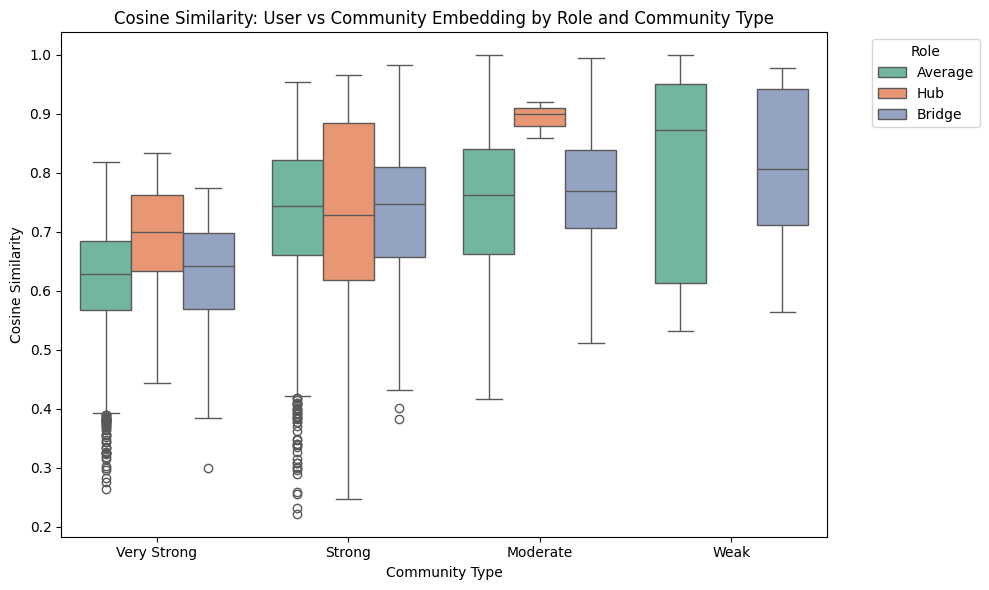

In [27]:
# Plotting Cosine Similarity by Role and Community Type
plt.figure(figsize=(10,6))
sns.boxplot(data=users_role, x='community_type', y='cosine_similarity', hue='role', palette='Set2')
# sns.swarmplot(data=users_role, x='community_type', y='cosine_similarity', hue='role', dodge=True, color='k', size=3, alpha=0.6)
plt.title('Cosine Similarity: User vs Community Embedding by Role and Community Type')
plt.ylabel('Cosine Similarity')
plt.xlabel('Community Type')
plt.legend(title='Role', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

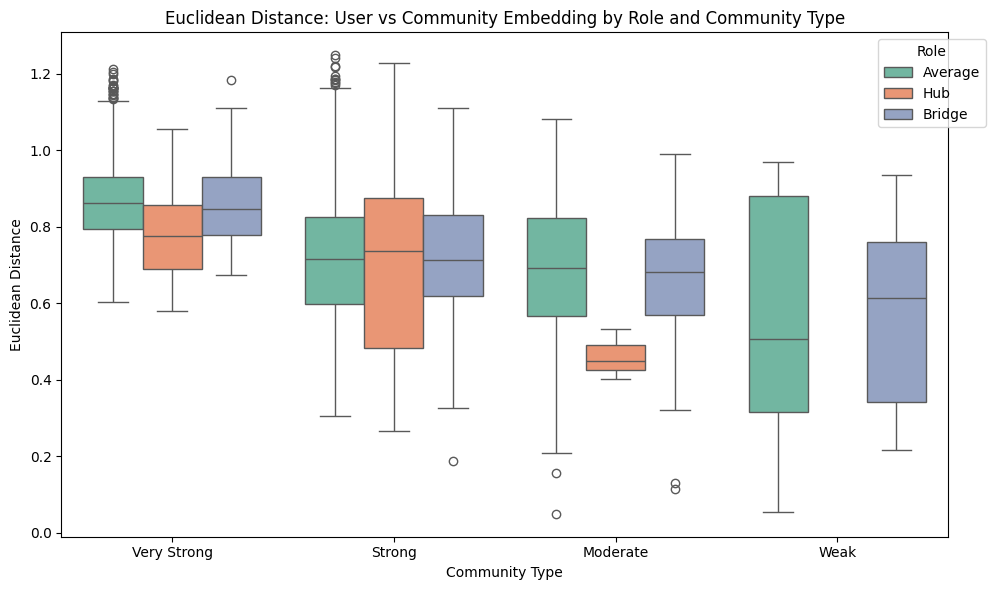

In [33]:
# Plotting Euclidean Distance by Role and Community Type
plt.figure(figsize=(10,6))
sns.boxplot(data=users_role, x='community_type', y='euclidean_distance', hue='role', palette='Set2')
# sns.swarmplot(data=users_role, x='community_type', y='euclidean_distance', hue='role', dodge=True, color='k', size=3, alpha=0.6)
plt.title('Euclidean Distance: User vs Community Embedding by Role and Community Type')
plt.ylabel('Euclidean Distance')
plt.xlabel('Community Type')
plt.legend(title='Role', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

In [31]:
# Summary statistics per role and community type
summary_stats = users_role.groupby(['community_type', 'role']).agg(
    count=('id', 'count'),
    mean_cosine=('cosine_similarity', 'mean'),
    median_cosine=('cosine_similarity', 'median'),
    std_cosine=('cosine_similarity', 'std'),
    mean_euc=('euclidean_distance', 'mean'),
    median_euc=('euclidean_distance', 'median'),
    std_euc=('euclidean_distance', 'std')
).reset_index()

summary_stats.to_csv('../../src/research_question/rq2_summary_stats.csv', index=False)
summary_stats

,community_type,role,count,mean_cosine,median_cosine,std_cosine,mean_euc,median_euc,std_euc
0,Moderate,Average,252,0.743061,0.761546,0.124207,0.693222,0.690579,0.182905
1,Moderate,Bridge,46,0.770521,0.768476,0.108047,0.652912,0.680476,0.182728
2,Moderate,Hub,3,0.892246,0.899517,0.031480,0.461002,0.448291,0.066907
3,Strong,Average,3636,0.730907,0.743460,0.118374,0.715558,0.716296,0.161770
4,Strong,Bridge,252,0.729914,0.746995,0.111363,0.718419,0.711343,0.155377
5,Strong,Hub,140,0.735453,0.728816,0.152634,0.692294,0.736456,0.224010
6,Very Strong,Average,3254,0.620213,0.628862,0.087105,0.865957,0.861555,0.098468
7,Very Strong,Bridge,151,0.629229,0.641939,0.085206,0.855681,0.846240,0.097031
8,Very Strong,Hub,121,0.685714,0.699812,0.091207,0.784858,0.774839,0.112588
9,Weak,Average,9,0.800800,0.871873,0.176149,0.556402,0.506216,0.316098


/tmp/ipykernel_9346/3372799676.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


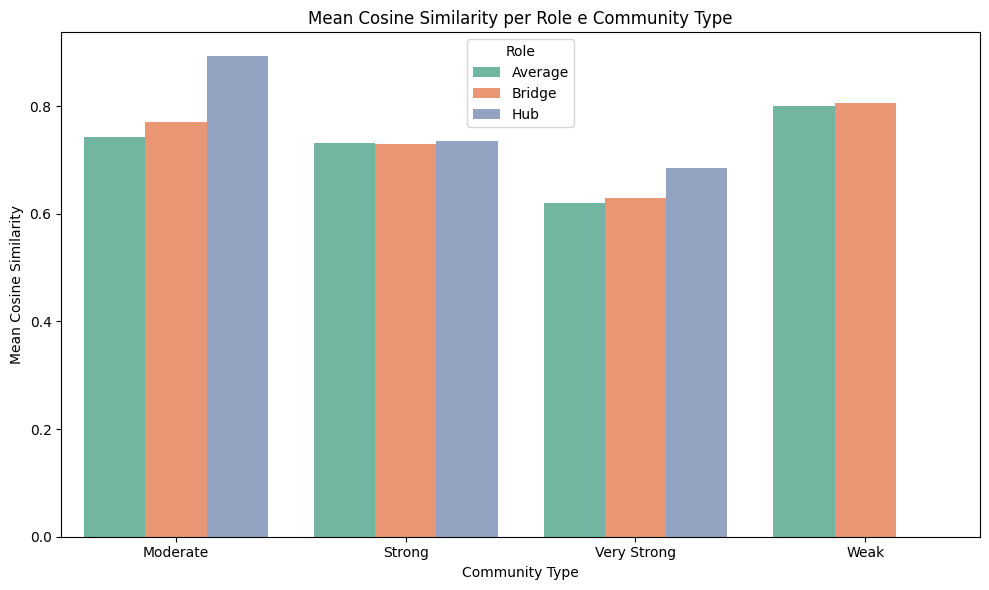

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=summary_stats,
    x='community_type',
    y='mean_cosine',
    hue='role',
    palette='Set2',
    ci='sd' 
)
plt.title('Mean Cosine Similarity per Role e Community Type')
plt.ylabel('Mean Cosine Similarity')
plt.xlabel('Community Type')
plt.legend(title='Role')
plt.tight_layout()
plt.show()

/tmp/ipykernel_9346/893125867.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


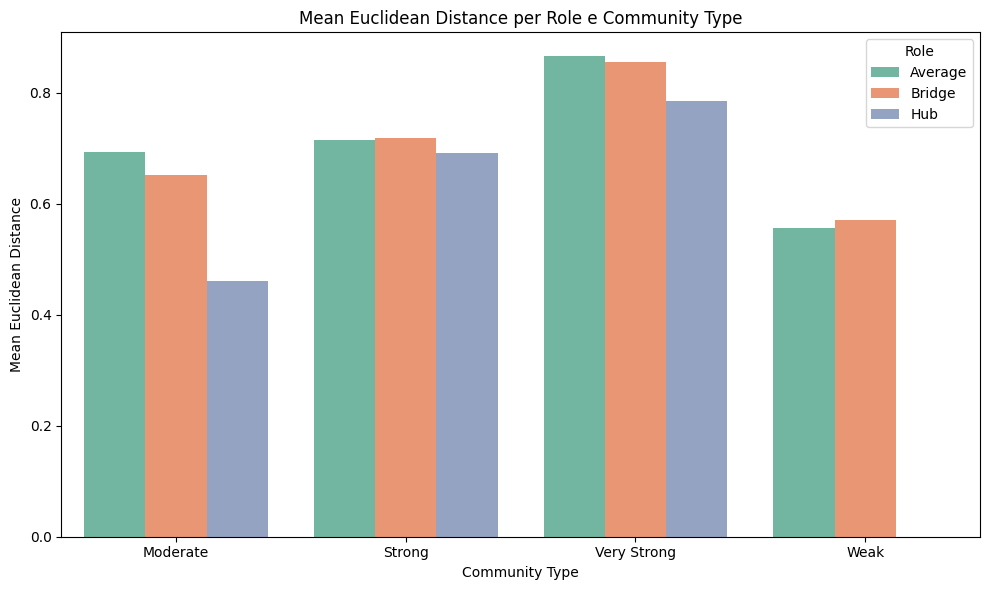

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=summary_stats,
    x='community_type',
    y='mean_euc',
    hue='role',
    palette='Set2',
    ci='sd' 
)
plt.title('Mean Euclidean Distance per Role e Community Type')
plt.ylabel('Mean Euclidean Distance')
plt.xlabel('Community Type')
plt.legend(title='Role')
plt.tight_layout()
plt.show()

##### Considerazione eventuale

In [37]:
# Hub vs Bridge across all communities
hub_cos = users_role.loc[users_role['role']=='Hub', 'cosine_similarity']
bridge_cos = users_role.loc[users_role['role']=='Bridge', 'cosine_similarity']

# --- 1. Test di normalità ---
shapiro_hub = shapiro(hub_cos)
shapiro_bridge = shapiro(bridge_cos)
print(f"Shapiro Hub: stat={shapiro_hub.statistic:.3f}, p={shapiro_hub.pvalue:.3e}")
print(f"Shapiro Bridge: stat={shapiro_bridge.statistic:.3f}, p={shapiro_bridge.pvalue:.3e}")

# --- 2. Test omogeneità varianze ---
levene_test = levene(hub_cos, bridge_cos)
print(f"Levene test: stat={levene_test.statistic:.3f}, p={levene_test.pvalue:.3e}")

# --- 3. Scelta del test ---
if shapiro_hub.pvalue > 0.05 and shapiro_bridge.pvalue > 0.05:
    # Normali
    if levene_test.pvalue > 0.05:
        stat, p = ttest_ind(hub_cos, bridge_cos, equal_var=True)
        test_name = "T-test var=equal"
    else:
        stat, p = ttest_ind(hub_cos, bridge_cos, equal_var=False)
        test_name = "T-test var=unequal"
else:
    # Non normali → Mann-Whitney
    stat, p = mannwhitneyu(hub_cos, bridge_cos, alternative='two-sided')
    test_name = "Mann-Whitney"

print(f"{test_name} Hub vs Bridge (cosine similarity): stat={stat:.3f}, p={p:.3e}")

Shapiro Hub: stat=0.987, p=1.463e-02
Shapiro Bridge: stat=0.997, p=6.350e-01
Levene test: stat=4.562, p=3.303e-02
Mann-Whitney Hub vs Bridge (cosine similarity): stat=63481.000, p=2.414e-01
